# Group 2: Phase 2 - Cats vs Dogs Detector (CaDoD)

## Team Members

* Ben Perkins
* Lauren Madar
* Mangesh Walimbe
* Samin Barghan

![](./other/team.png)

## Project Abstract - updated for Phase 2

One of the fundamental tasks in classifying images is object detection within images. Algorithms often employ a ‘bounding box’ tool. To study bounding boxes, our team first evaluated 3 models with GridSearchCV, to be trained on existing bounding box data for the purpose of predicting bounding boxes.  The best model was used for bounding box prediction.

For the second phase, we created several PyTorch models with classification and bounding box predictions using Cross Entropy and Mean Squared Error loss functions. PyTorch allows for a much simpler modeling, training and prediction process, though the Nvidia GPU made a move to Google Colab necessary.

## Project Description

The purpose of this project is create an end to end process in machine learning to create an object classifier and bounding box predictor for cat and dog images. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB images and have bounding box coordinates stored in a .csv file. In order to create a detector, we will first have to preprocess the images to be all of the same shapes, and flatten them from a 3D array to 2D. Then we will feed this array into a linear localization predictor and a logistic regression model to predict labels and bounding boxes.

### Articles for PyTorch

https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Data Description - small updates for Phase 2 (connector to gdrive)

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). It contains a total of 12,966 images of dogs and cats.


Image bounding boxes are stored in the csv file `cadod.csv`. The following describes whats contained inside the csv.

* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.

The attributes have the following definitions:

* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.

Identifying columns: ImageID, Source, LabelName, Confidence

Dimensional and positional columns: XMin, XMax, YMin,YMax, XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y

Bounding box and image descriptive columns: IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside

When we look at a few random images, we can see that the photos vary in color and have different shapes and sizes. Also, we can see a photo with both a cat and dog, with the cat being barely visible (bottom row middle) so this shows any classifier fit on this type of photos will have to be robust.

![Sample Images](https://iu.instructure.com/users/6469957/files/119176770/preview?verifier=vwgzljiRpIRlNhVQK4aPqNwqrlygkVDkhnAhSrNf)

The first step to prepare data must be to standardize the images. Photos will have to be reshaped before modeling so that all images have the same shape and size. One approach we may use would be to load all photos and look at the distribution of the photo widths and heights then determine a new image size that fits the majority of the images. Smaller size allows a model to train more quickly. Another approach would be to start with a fixed size of 200x200 pixels. We can also filter color images to determine where the majority or highest density of each color pixel lies within the image.

The metadata contained in the csv file will need to be matched to each image file, and during Exploratory Data Analysis, we will determine relationships between any of the columns using pandas. For example, how many images contain more than one cat or dog (IsGroupOf)? How many of those images have IsOccluded, IsTruncated, IsInside? Can we determine if the bounding box of one object is larger than the other in order to guess the ‘main’ object? This will drive creation of additional features.

The code and project files are stored in a GitHub repository: i526Sp21Group2 (SEE PDF). We will impute missing data and document the strategy used, if needed (depending on the results of EDA). NumPy DataFrames embedded in our project Jupyter Notebook will track our exploration and transformation of data and engineering of any features ahead of training and fitting. Other Python libraries may be used for visualizations and will be documented.

In [2]:
# new for Phase 2
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

In [11]:
useLocalInJupyter = False # set to False if using Colab, set to True if using locally

In [12]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
import tarfile
 
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
 
from sklearn.neighbors import KNeighborsRegressor
 
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
 
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, confusion_matrix, average_precision_score, plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
from tqdm.notebook import tqdm
import warnings
 
 
 
#### Add PyTorch stuff
import torch
import torch.nn
import torch.utils
from torch.optim import Adam
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import torch.nn.functional as F

# debugger
#import pdb
#pdb.set_trace()

# Import Data - unchanged for Phase 2

### Unarchive data

Place the cadod.tar.gz into the same folder as this notebook. We've already extracted the files into the ./data folder (to prevent committing the large gz file to github).

In [8]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [9]:
if useLocalInJupyter == False:
    path = 'content/drive/MyDrive/FinalProject/data/cadod/'
    extract_tar('/content/drive/MyDrive/FinalProject/data/cadod.tar.gz', path)
 
if useLocalInJupyter == True:
    path = './data/cadod/'
    extract_tar('./data/cadod.tar.gz', path)

  0%|          | 0/25936 [00:00<?, ?it/s]

### Load bounding box meta data

The metadata in the CSV file is for training for the bounding box prediction only.

In [10]:
if useLocalInJupyter == True:
    df = pd.read_csv('./data/cadod.csv')
if useLocalInJupyter == False:
    df = pd.read_csv('/content/drive/MyDrive/FinalProject/data/cadod.csv')

In [ ]:
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000b9fcba019d36,xclick,/m/0bt9lr,1,0.165000,0.903750,0.268333,0.998333,1,1,0,0,0,0.636250,0.903750,0.748750,0.165000,0.268333,0.506667,0.998333,0.661667
1,0000cb13febe0138,xclick,/m/0bt9lr,1,0.000000,0.651875,0.000000,0.999062,1,1,0,0,0,0.312500,0.000000,0.317500,0.651875,0.000000,0.410882,0.999062,0.999062
2,0005a9520eb22c19,xclick,/m/0bt9lr,1,0.094167,0.611667,0.055626,0.998736,1,1,0,0,0,0.487500,0.611667,0.243333,0.094167,0.055626,0.226296,0.998736,0.305942
3,0006303f02219b07,xclick,/m/0bt9lr,1,0.000000,0.999219,0.000000,0.998824,1,1,0,0,0,0.508594,0.999219,0.000000,0.478906,0.000000,0.375294,0.720000,0.998824
4,00064d23bf997652,xclick,/m/0bt9lr,1,0.240938,0.906183,0.000000,0.694286,0,0,0,0,0,0.678038,0.906183,0.240938,0.522388,0.000000,0.370000,0.424286,0.694286


# Exploratory Data Analysis - unchanged for Phase 2

## Statistics

In [ ]:
print(f"There are a total of {len(glob.glob1(path, '*.jpg'))} images")

There are a total of 12966 images


In [ ]:
print(f"The total size is {os.path.getsize(path)/1000} MB")

The total size is 1134.592 MB


In [ ]:
df.shape

(12966, 21)

Replace `LabelName` with human readable labels

In [ ]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [ ]:
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

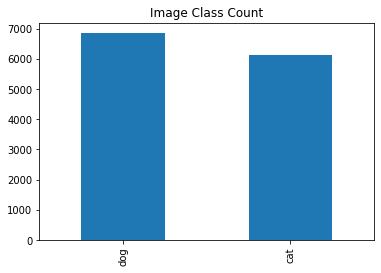

In [ ]:
df.LabelName.value_counts().plot(kind='bar')
plt.title('Image Class Count')
plt.show()

In [ ]:
df.describe()

,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
count,12966.0,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000
mean,1.0,0.099437,0.901750,0.088877,0.945022,0.464754,0.738470,0.013651,0.045427,0.001157,0.390356,0.424582,0.494143,0.506689,0.275434,0.447448,0.641749,0.582910
std,0.0,0.113023,0.111468,0.097345,0.081500,0.499239,0.440011,0.118019,0.209354,0.040229,0.358313,0.441751,0.405033,0.462281,0.415511,0.401580,0.448054,0.403454
min,1.0,0.000000,0.408125,0.000000,0.451389,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.0,0.000000,0.830625,0.000000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221293,0.096875,0.285071,0.130000,0.024323,0.218333,0.405816,0.400000
50%,1.0,0.061250,0.941682,0.059695,0.996875,0.000000,1.000000,0.000000,0.000000,0.000000,0.435625,0.415625,0.531919,0.623437,0.146319,0.480838,0.825000,0.646667
75%,1.0,0.167500,0.998889,0.144853,0.999062,1.000000,1.000000,0.000000,0.000000,0.000000,0.609995,0.820000,0.787500,0.917529,0.561323,0.729069,0.998042,0.882500
max,1.0,0.592500,1.000000,0.587088,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999375,0.999375,1.000000,0.999375,0.999375,0.999375,1.000000,0.999375


## Sample of Images

By plotting random samples of the images along with the bounding boxes and XClick points, we see that every image has a bounding box but not every image has valid (positive) XClick information. From the descriptions on the CaDoD site, the bounding boxes were either derived from the extreme points clicked (aka XClick) by a human, or provided in some other way (prediction or manually drawn as a box). 

Further, it seems that the XClick items follow no system. For example, they are not in a predictable clockwise or counterclockwise ordering, they do not seem to start on a particular edge (like left side vs right side).

Since the bounding box information is more widely available and, where XClick is present, bounding box is derived from XClick, we can drop the XClick feature later on and just focus more on examining the bounding box attributes.

content/drive/MyDrive/FinalProject/data/cadod/c685e1916f645376.jpg
content/drive/MyDrive/FinalProject/data/cadod/6bbfd8ab5ed4274f.jpg
content/drive/MyDrive/FinalProject/data/cadod/2cfa6bbaf0452898.jpg
content/drive/MyDrive/FinalProject/data/cadod/0197e795c336a598.jpg
content/drive/MyDrive/FinalProject/data/cadod/6790b072e694d4bb.jpg
content/drive/MyDrive/FinalProject/data/cadod/8fedda00db506f77.jpg


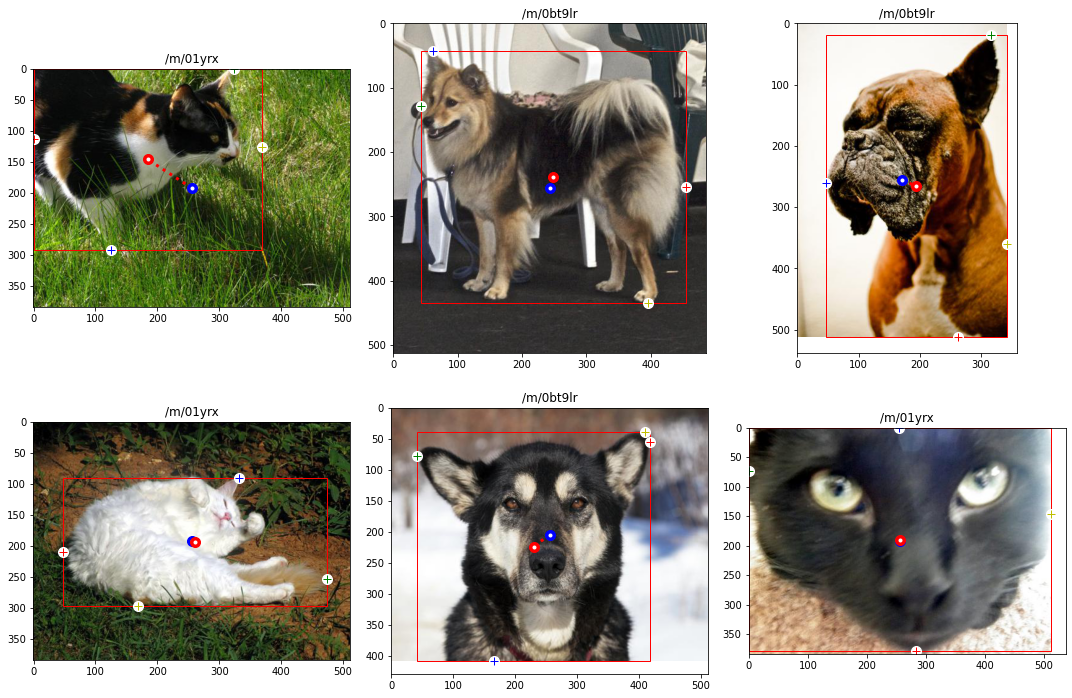

In [ ]:
# plot random 6 images (original size)
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    print(path + df.ImageID.values[j] + '.jpg')
    img = mpimg.imread(path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    xclick_xcoords = df.iloc[j,13:17]*w
    xclick_ycoords = df.iloc[j,17:21]*h
    
    centerimg = [w/2, h/2]
    centerbox = [(coords[1]*w-coords[0]*w)/2 + coords[0]*w, (coords[3]*h-coords[2]*h)/2 + coords[2]*h]
    
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    
    # Plot the bounding box as a red border
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))
    
    ax[i].plot([centerimg[0], centerbox[0]],[centerimg[1], centerbox[1]],linestyle='dotted',linewidth=3,color='red')
    ax[i].plot(centerimg[0], centerimg[1],'bo', markersize=10)
    ax[i].plot(centerimg[0], centerimg[1],'w.')
    ax[i].plot(centerbox[0], centerbox[1],'ro', markersize=10)
    ax[i].plot(centerbox[0], centerbox[1],'w.')
    
    # If this image has valid positive XClick coords, plot those points
    if xclick_xcoords.any() < 0 or xclick_ycoords.any() < 0 :
        print("cannot plot, invalid (negative) xclick!")
    else :
        # plot each XClick point in scale on the image, 1 = blue, 2 = green, 3 = yellow, 4 = red
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'w.', markersize=20, label="1")
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'b+', markersize=8)
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'w.', markersize=20, label="2")
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'g+', markersize=8)
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'w.', markersize=20, label="3")
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'y+', markersize=8)
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'w.', markersize=20, label="4")
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'r+', markersize=8)
        
plt.tight_layout()
plt.show()

Let's look at the IsDepiction column.  This seems to indicate if the image is a depiction (drawing, painting, not a 'real' animal photo).

In [ ]:
depictioncount = Counter(df.IsDepiction)
depictioncount

Counter({0: 12371, 1: 592, -1: 3})

There are 3 items with -1 values. Let's look at those images to see what they're like.

In [ ]:
df[df.IsDepiction < 0]

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
6878,004b6bf1ef1414b6,activemil,cat,1,0.002500,0.919375,0.002506,0.950710,-1,-1,...,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7084,021fd3fec9e6a438,activemil,cat,1,0.107500,0.957500,0.165625,0.884375,-1,-1,...,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7170,03c7118d468d94aa,activemil,cat,1,0.075548,0.874898,0.219601,0.900181,-1,-1,...,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Let's look at the 3 images with IsDepiction = -1

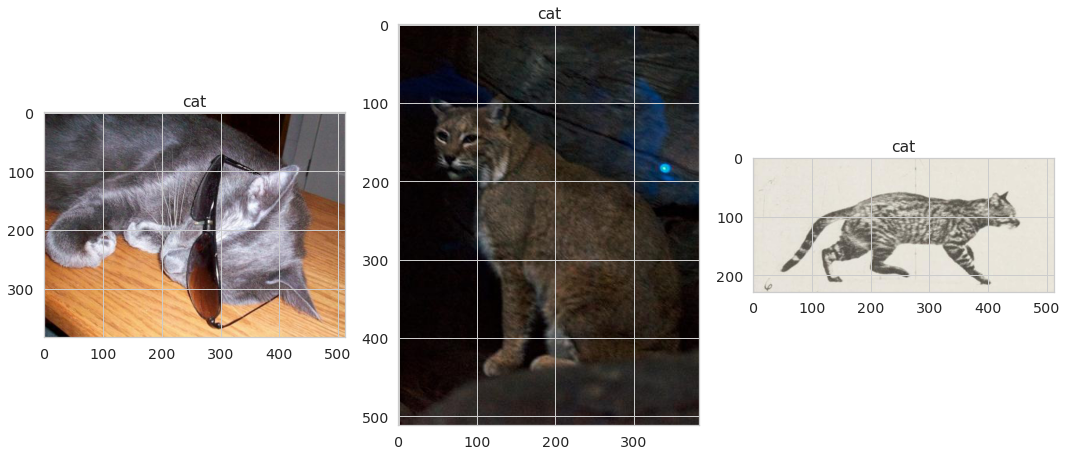

In [ ]:
# plot 3 "IsDepiction" = -1 images.
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()
depictionimgs = df[df.IsDepiction < 0].to_numpy()
iterax = 0
for item in depictionimgs:
    img = mpimg.imread(path + item[0] + '.jpg')
    ax[iterax].imshow(img)
    ax[iterax].set_title(item[2])
    iterax += 1
plt.tight_layout()
plt.show()

Well, it looks from the dataframe above that these 3 images from Source = "activemil" don't have any XClick info or other info, though they do have bounding boxes.  These are NOT depictions/drawings though, so we can look for -1 values to clean up in our Feature Engineering stage.

What else can we tell from this?  Let's see if there is any other -1 data to deal with.

In [ ]:
occludecount = Counter(df.IsOccluded)
truncatecount = Counter(df.IsTruncated)
groupcount = Counter(df.IsGroupOf)
insidecount = Counter(df.IsInside)
print (occludecount, truncatecount, groupcount, insidecount)

Counter({0: 6934, 1: 6029, -1: 3}) Counter({1: 9578, 0: 3385, -1: 3}) Counter({0: 12783, 1: 180, -1: 3}) Counter({0: 12945, 1: 18, -1: 3})


Gladly, this tells us that the same 3 images have -1 data, but others are ok (using either 0 or 1 for the IsOccluded, IsTruncated, IsGroupOf or IsInside columns.

## Image shapes and sizes

Go through all images and record the shape of the image in pixels and the memory size

In [ ]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))
img_format = []
for i,f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path+'/'+f
    img = Image.open(file)
    img_shape.append(f"{img.size[0]}x{img.size[1]}")
    imgratio = img.size[0]/img.size[1]
    if imgratio > 1 :
        img_format.append('landscape')
    elif imgratio < 1:
        img_format.append('portrait')
    else:
        img_format.append('square')
    img_size[i] += os.path.getsize(file)
    img.close() # cleanup!

  0%|          | 0/12966 [00:00<?, ?it/s]

Count all the different image shapes

In [ ]:

img_shape_count = Counter(img_shape)
img_format_count = Counter(img_format)
img_format_count

Counter({'landscape': 9657, 'square': 1216, 'portrait': 2093})

In [ ]:
# create a dataframe for image shapes
img_df = pd.DataFrame(set(img_shape_count.items()), columns=['img_shape','img_count'])
img_df.shape

(594, 2)

In [ ]:
# create a dataframe for simple image aspect ratios
img_ratio_df = pd.DataFrame(set(img_format_count.items()), columns=['aspect_ratio','img_count'])
img_ratio_df.head()

,aspect_ratio,img_count
0,landscape,9657
1,square,1216
2,portrait,2093


There are a ton of different image shapes. Let's narrow this down by getting a sum of any image shape that has a count less than 100 and put that in a category called `other`

In [ ]:
img_df = img_df.append({'img_shape': 'other','img_count': img_df[img_df.img_count < 100].img_count.sum()}, 
                       ignore_index=True)

Drop all image shapes

In [ ]:
img_df = img_df[img_df.img_count >= 100]

Check if the count sum matches the number of images

In [ ]:
img_df.img_count.sum() == df.shape[0]

True

## Depiction Images

Now, let's look at a random sample of images marked as "Depictions" (IsDepiction = 1). This would indicate a drawing or other nonstandard image representation of a dog or cat and we need to verify this assumption.

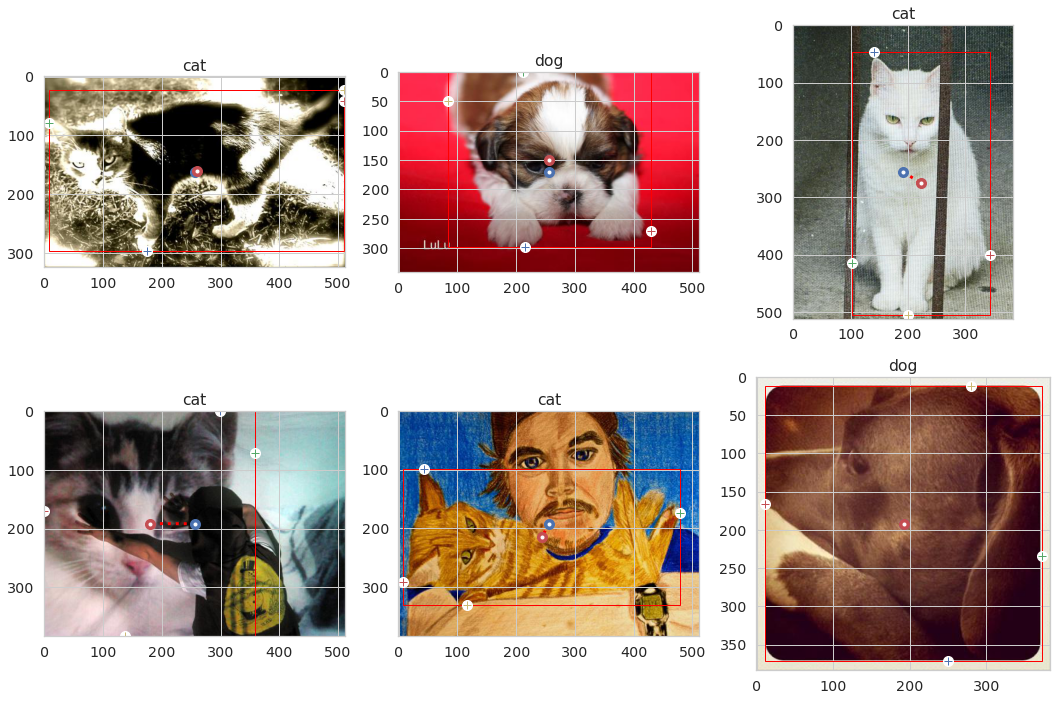

In [ ]:
# Now let's look at a random sample of the "depiction" images.

# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

depictionitems = df[df["IsDepiction"] > 0]


for i,j in enumerate(np.random.choice(depictionitems.shape[0], size=6, replace=False)):
    img = mpimg.imread(path + depictionitems.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = depictionitems.iloc[j,4:8]
    xclick_xcoords = depictionitems.iloc[j,13:17]*w
    xclick_ycoords = depictionitems.iloc[j,17:21]*h
    
    centerimg = [w/2, h/2]
    centerbox = [(coords[1]*w-coords[0]*w)/2 + coords[0]*w, (coords[3]*h-coords[2]*h)/2 + coords[2]*h]
    
    ax[i].imshow(img)
    ax[i].set_title(depictionitems.LabelName.values[j])
    
    # Plot the bounding box as a red border
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))
    
    ax[i].plot([centerimg[0], centerbox[0]],[centerimg[1], centerbox[1]],linestyle='dotted',linewidth=3,color='red')
    ax[i].plot(centerimg[0], centerimg[1],'bo', markersize=10)
    ax[i].plot(centerimg[0], centerimg[1],'w.')
    ax[i].plot(centerbox[0], centerbox[1],'ro', markersize=10)
    ax[i].plot(centerbox[0], centerbox[1],'w.')
    
    # If this image has valid positive XClick coords, plot those points
    if xclick_xcoords.any() < 0 or xclick_ycoords.any() < 0 :
        print("cannot plot, invalid (negative) xclick!")
    else :
        # plot each XClick point in scale on the image, 1 = blue, 2 = green, 3 = yellow, 4 = red
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'w.', markersize=20, label="1")
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'b+', markersize=8)
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'w.', markersize=20, label="2")
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'g+', markersize=8)
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'w.', markersize=20, label="3")
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'y+', markersize=8)
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'w.', markersize=20, label="4")
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'r+', markersize=8)
        
plt.tight_layout()
plt.show()

Well, it doesn't seem like IsDepiction tells us a whole lot.  Sometimes, IsDepiction is set to 1 for paintings, statues, or just 'heavily filtered' or artistically distorted photos, but also photos that have low light or are black and white are tagged with this feature.

## Plot aspect ratio

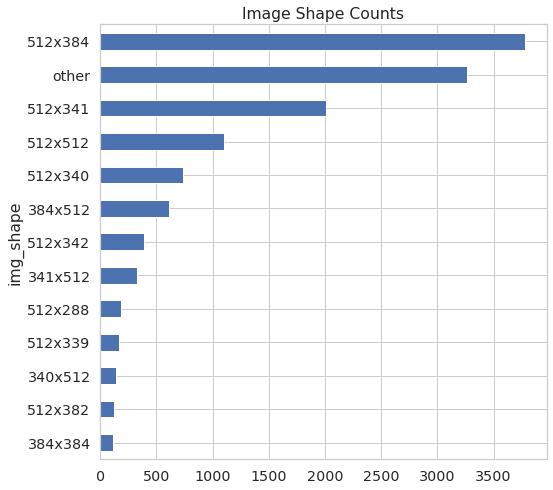

In [ ]:
img_df.sort_values('img_count', inplace=True)
img_df.plot(x='img_shape', y='img_count', kind='barh', figsize=(8,8), legend=False)
plt.title('Image Shape Counts')
plt.show()

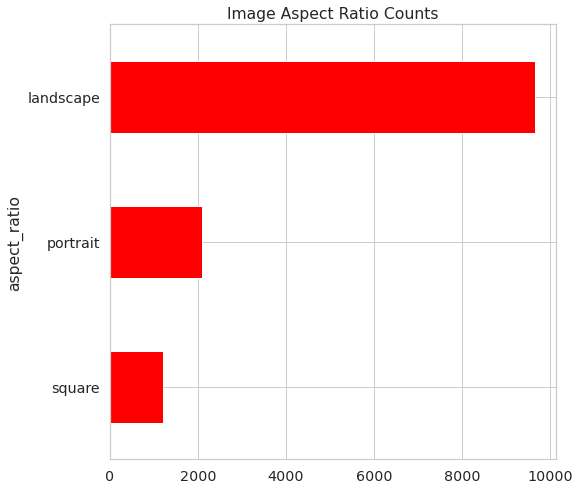

In [ ]:
img_ratio_df.sort_values('img_count', inplace=True)
img_ratio_df.plot(x='aspect_ratio', y='img_count', kind='barh', color='red', figsize=(8,8), legend=False)
plt.title('Image Aspect Ratio Counts')
plt.show()

In [ ]:
np.min(img_size), np.max(img_size)

(4471.0, 502800.0)

In [ ]:
# convert to megabytes
img_size = img_size / 1000
np.min(img_size), np.max(img_size)

(4.471, 502.8)

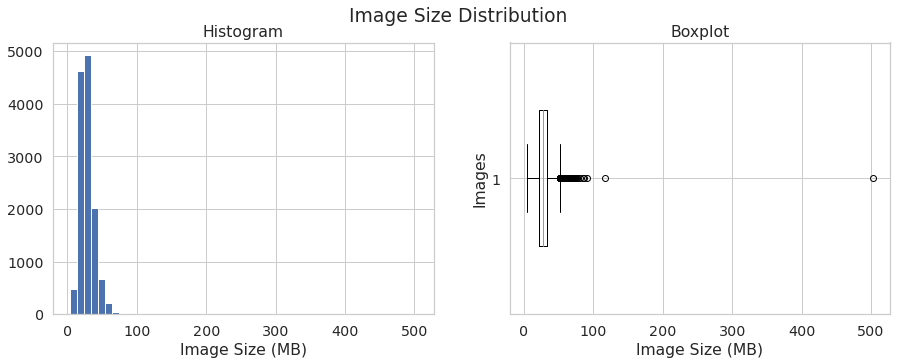

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

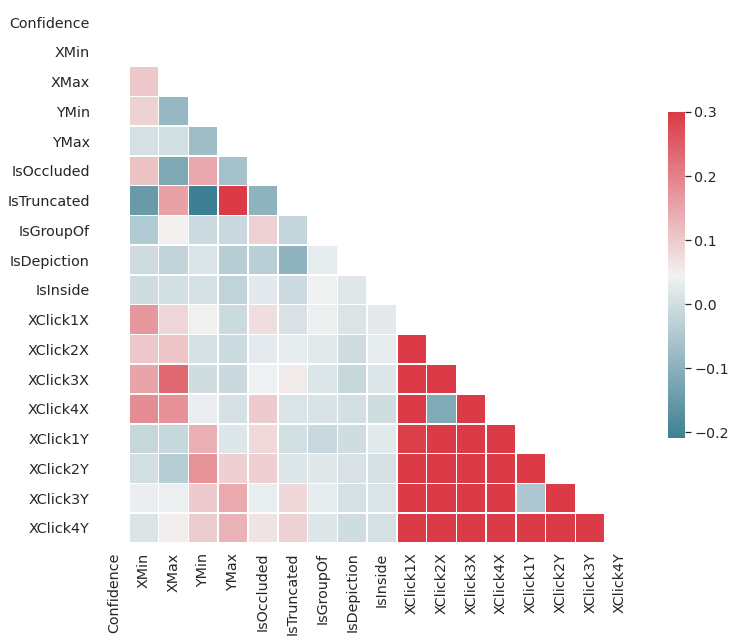

In [ ]:
# data correlation LLM
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)

class_labels = ["cat", "dog"]

# compute the correlation matrix
corr = df.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

# **PyTorch Implementation**

In [21]:
# Load the TensorBoard notebook extension
#%load_ext TensorBoard

# Configure device for gpu or cpu depending on what's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


In [23]:
#PyTorch expects a dataset class to call it's methods
##some of the finer details can be found here <https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html>
 
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        self.root_dir = root_dir
        self.samples = pd.read_csv(csv_file)
        #torch pipeline to transform images to tensors
        self.transform = transform
 
    def __len__(self):
        return len(self.samples)
 
    #Return the image(as a tensor) and the target(dictionary of tensors)
    def __getitem__(self, idx):
      cat_label = '/m/01yrx'
      img_name = os.path.join(self.root_dir,self.samples.iloc[idx,0]+'.jpg')
      image = Image.open(img_name).convert('RGB')
      
      if self.transform:
        image = self.transform(image)
   
      if self.samples.iloc[idx,2] == cat_label:
        label = torch.as_tensor(0, dtype = torch.int64)
      else:
        label = torch.as_tensor(1, dtype = torch.int64)
     
      image_id = torch.as_tensor(idx, dtype = torch.int64)
      
      ##save that box as a tensor
      box = torch.as_tensor([self.samples.iloc[idx, 4]
             , self.samples.iloc[idx, 6]
             , self.samples.iloc[idx, 5]
             , self.samples.iloc[idx, 7]], dtype = torch.float32)
      area = [(self.samples.iloc[idx, 5] - self.samples.iloc[idx, 4]) * (self.samples.iloc[idx, 7] - self.samples.iloc[idx, 6])]
      area_at = torch.as_tensor(area, dtype = torch.float32)
     
      iscrowd = torch.zeros((1,), dtype=torch.int64)
      
      target = {}
      target['boxes'] = box
      target['labels'] = label
      target['image_id'] = image_id
      target['area'] = area_at
      target['iscrowd'] = iscrowd
      
      return image, target

In [24]:
#Set transform process on PIL Image item from custom dataset 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128))
])
 
if useLocalInJupyter == False:
    cadod_csv_file = '/content/drive/MyDrive/Colab Notebooks/data/cadod.csv'
    cadod_dir = '/content/drive/MyDrive/Colab Notebooks/data/cadod'
    
if useLocalInJupyter == True:
    cadod_csv_file = './data/cadod.csv'
    cadod_dir = './data/cadod'
 
cadod_data = CustomDataset(csv_file=cadod_csv_file, root_dir=cadod_dir, transform=transform )



In [25]:
len(cadod_data)

12966

In [26]:

test_split = .2
 
dataset_size = len(cadod_data)
indices = list(range(dataset_size))
 
split = int(np.floor(test_split * dataset_size))
np.random.seed(27)
np.random.shuffle(indices)
 
train_indices, test_indices = indices[split:], indices[:split]
 
#call the subset sampler to sample our data
train_sampler = SubsetRandomSampler(train_indices) #random sample for the indices for training data and test data
test_sampler = SubsetRandomSampler(test_indices)

In [27]:
train_dataloader0 = DataLoader(cadod_data, batch_size=4, sampler=train_sampler)
test_dataloader0 = DataLoader(cadod_data, batch_size=2, sampler=test_sampler)

train_dataloader1 = DataLoader(cadod_data, batch_size=10, sampler=train_sampler)
test_dataloader1 = DataLoader(cadod_data, batch_size=2, sampler=test_sampler)

train_dataloader2 = DataLoader(cadod_data, batch_size=30, sampler=train_sampler)
test_dataloader2 = DataLoader(cadod_data, batch_size=6, sampler=test_sampler)

train_dataloader3 = DataLoader(cadod_data, batch_size=80, sampler=train_sampler)
test_dataloader3 = DataLoader(cadod_data, batch_size=20, sampler=test_sampler)

train_dataloader4 = DataLoader(cadod_data, batch_size=500, sampler=train_sampler)
test_dataloader4 = DataLoader(cadod_data, batch_size=100, sampler=test_sampler)

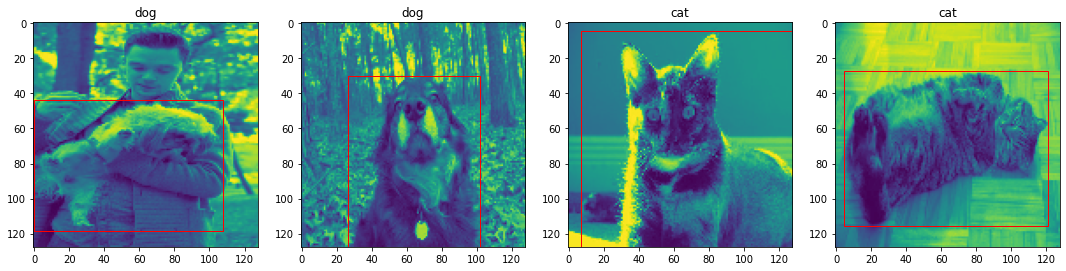

In [32]:
def show_dataloader_images(dataloader): 
  # show images with bounding boxes after loading via custom dataset
  for image_data in dataloader:
    #show the processed images
    image, target = image_data # image is a list of tensor images, target is a list of tensor ground truths
    numrows = int(np.ceil(len(image)/4))
 
    
    fig, ax = plt.subplots(nrows=numrows, ncols=4, sharex=False, sharey=False,figsize=(15,10))
    ax = ax.flatten()
    trans1 = transforms.ToPILImage()
    #show those images - to make sure that processing so far has gone according to plan
    for i, j in enumerate(image):
        subimg = trans1(j)
        ax[i].imshow(subimg)    
        label = target['labels'][i]
        
        if int(label) == 1:
            label = 'dog'
        else:
            label = 'cat'
            
        ax[i].set_title(label)

        ax[i].add_patch(plt.Rectangle((target['boxes'][i][0]*128, target['boxes'][i][1]*128), 
                                    (target['boxes'][i][2] - target['boxes'][i][0])*128, (target['boxes'][i][3]-target['boxes'][i][1])*128, 
                                    edgecolor='red', facecolor='none'))
    plt.tight_layout()
    plt.show()
    break
    
show_dataloader_images(train_dataloader0)

In [33]:
class Net(nn.Module): # This one still needs debugging, won't train successfully.
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.fc_classification = nn.Linear(in_features=4608, out_features=128)
    self.out_classification = nn.Linear(in_features=128, out_features=10)
    self.fc_regression = nn.Linear(in_features=4608, out_features=128)
    self.out_regression = nn.Linear(in_features=128, out_features=1)
 
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool1(x)
 
    x1 = F.relu(self.fc_classification(x))
    x2 = F.log_softmax(self.out_classification(x1), dim=1)
 
    x2 = F.relu(self.fc_regression(x))
    x2 = self.out_regression(x2)
    return x1, x2

In [35]:
# net = Net() # This one is buggy :(
# net = net.to(device)

In [36]:
class SimpleLinearNet(nn.Module):
  def __init__(self):
      super(SimpleLinearNet, self).__init__()
      self.fc1 = nn.Linear(in_features=16384, out_features=500) #Image size 128*128
      self.fc2 = nn.Linear(in_features=500, out_features=500) 
      self.do1 = nn.Dropout(0.5) # (for regularization)
      self.fc3 = nn.Linear(in_features=500, out_features=500) 
      self.do2 = nn.Dropout(0.25) # (for regularization)
      
      self.out_labels = nn.Linear(in_features=500, out_features=2) # Output layer
      self.out_boxes = nn.Linear(in_features=500,out_features=4)
  
  def forward(self, x):
      x = x.view(-1, self.flatten_image(x)) 
      x = F.relu(self.fc1(x)) 
      x = F.relu(self.fc2(x)) 
      x = self.do1(x) 
      x = F.relu(self.fc3(x)) 
      x = self.do2(x) 
      output_labels = self.out_labels(x)
      output_boxes = self.out_boxes(x)
      return output_labels, output_boxes

  def flatten_image(self, x): 
      size = x.size()[1:] 
      num_features = 1
      for s in size:
         num_features *= s
      return num_features

In [37]:
# Model instances to run with different size train/test sets
net0 = SimpleLinearNet()
net0 = net0.to(device) #make sure it points to GPU
for name, param in net0.named_parameters():
  print(name, '\t', param.shape)

net1 = SimpleLinearNet()
net1 = net1.to(device)

net2 = SimpleLinearNet()
net2 = net2.to(device)

net3 = SimpleLinearNet()
net3 = net3.to(device)

net4 = SimpleLinearNet()
net4 = net4.to(device)

fc1.weight 	 torch.Size([500, 16384])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([500, 500])
fc2.bias 	 torch.Size([500])
fc3.weight 	 torch.Size([500, 500])
fc3.bias 	 torch.Size([500])
out_labels.weight 	 torch.Size([2, 500])
out_labels.bias 	 torch.Size([2])
out_boxes.weight 	 torch.Size([4, 500])
out_boxes.bias 	 torch.Size([4])


In [38]:
results_df = pd.DataFrame(data=[],columns=['epoch', 'train_accuracy', 'test_accuracy', 'train_loss', 'test_loss'])
results_df.describe()

,epoch,train_accuracy,test_accuracy,train_loss,test_loss
count,0,0,0,0,0
unique,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN


In [39]:
def train(net, trainloader, testloader, epochs, log_dir1=None, log_dir2=None):
  eta = 0.001
  writer = SummaryWriter(log_dir1)
  writer2 = SummaryWriter(log_dir2)

  criterion1 = nn.CrossEntropyLoss()
  criterion2 = nn.MSELoss()

  optimizer = Adam(net.parameters(), lr=eta, weight_decay=0)

  train_accuracy = [0] * epochs
  test_accuracy = [0] * epochs
  train_loss = [0] * epochs
  test_loss = [0] * epochs

  for epoch in tqdm(range(epochs)):
    correct = 0
    total = 0
    running_loss = 0

    correct_val = 0
    total_val=0
    running_loss_val = 0

    for batch, data in enumerate(trainloader):
      
      imagetensors, target = data
      labeltensor, boxtensor = target['labels'], target['boxes']
      
      inputs, labels, bbox = imagetensors.to(device), labeltensor.to(device), boxtensor.to(device)
      optimizer.zero_grad()

      outputs1, outputs2 = net(inputs) #forward pass # classification # regression

      _, predicted = torch.max(outputs1.data,1) #class
      predicted.to(device)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      CXE = criterion1(outputs1, labels) #NLL
      MSE = criterion2(outputs2, bbox.float()) #MSE

      # add weights
      loss = CXE + MSE # combined loss, add a multiplier to either to weight.
      loss.backward() #backward pass
      optimizer.step()
      running_loss += loss.item()
    print('Accuracy after epoch', epoch + 1, ':', 100 * correct / total)
    print('Loss after epoch', epoch + 1, ':', running_loss/total)
    
    #validation
    with torch.no_grad():
      for batch, data_val in enumerate(testloader):
        imaget_val, target_val = data_val
        labelt_val, boxt_val = target_val['labels'], target_val['boxes']
        # make sure the tensors are all on gpu
        imaget_val = imaget_val.to(device)
        labelt_val = labelt_val.to(device)
        boxt_val = boxt_val.to(device)

        outputs_val1, outputs_val2 = net(imaget_val) #forward pass
        
        outputs_val1 = outputs_val1.to(device)
        outputs_val2 = outputs_val2.to(device)

        _, predicted_val = torch.max(outputs_val1.data, 1)
        predicted_val.to(device)
        total_val += labelt_val.size(0)
        correct_val += (predicted_val == labelt_val).sum().item()
        loss_val1 = criterion1(outputs_val1, labelt_val)
        loss_val2 = criterion2(outputs_val2, boxt_val)
        loss_val = loss_val1 + loss_val2 # CXE + MSE
        running_loss_val += loss_val.item()
        

    train_accuracy[epoch] += 100 * correct / total # get train data accuracy
    test_accuracy[epoch] += 100 * correct_val/total_val # get test data accuracy
    
    print('Test Accuracy after epoch', epoch + 1, ':', 100 * correct_val / total_val)
    print('Test Loss after epoch', epoch + 1, ':', running_loss_val/total_val)

    train_loss[epoch] += running_loss # get train data cross entropy loss
    test_loss[epoch] += running_loss_val # get test data cross entropy loss
    results_df.loc[len(results_df.index)] = [epoch + 1,train_accuracy[epoch],test_accuracy[epoch],train_loss[epoch], test_loss[epoch]] 

    writer.add_scalar('accuracy', train_accuracy[epoch], epoch)
    writer2.add_scalar('accuracy', test_accuracy[epoch], epoch)


In [7]:
# train(net, train_dataloader, test_dataloader,3) # still need debugging on this one.

In [40]:
train(net0, train_dataloader0, test_dataloader0,3) # 3 epochs, 4 train images, 2 test images, CPU

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy after epoch 1 : 51.40268003470548
Loss after epoch 1 : 0.18178483940338452
Test Accuracy after epoch 1 : 49.98071731585036
Test Loss after epoch 1 : 0.3523726878228723
Accuracy after epoch 2 : 51.74973488865324
Loss after epoch 2 : 0.17629845844771885
Test Accuracy after epoch 2 : 46.934053220208256
Test Loss after epoch 2 : 0.3531387543016265
Accuracy after epoch 3 : 52.27031716957486
Loss after epoch 3 : 0.1760013484051542
Test Accuracy after epoch 3 : 53.33590435788662
Test Loss after epoch 3 : 0.3511276946672821


In [41]:
train(net1, train_dataloader1, test_dataloader1,3) # 3 epochs, 10 train images, 2 test images, CPU

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy after epoch 1 : 51.68225200038562
Loss after epoch 1 : 0.07343905591279783
Test Accuracy after epoch 1 : 53.22020825298882
Test Loss after epoch 1 : 0.3518819378418119
Accuracy after epoch 2 : 51.52800539863106
Loss after epoch 2 : 0.0705294596255946
Test Accuracy after epoch 2 : 53.33590435788662
Test Loss after epoch 2 : 0.3517112536086477
Accuracy after epoch 3 : 51.923262315627106
Loss after epoch 3 : 0.07051130689398298
Test Accuracy after epoch 3 : 53.33590435788662
Test Loss after epoch 3 : 0.3513373078823641


In [42]:
train(net2, train_dataloader2, test_dataloader2,3) # 3 epochs, 30 train images, 6 test images, CPU

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy after epoch 1 : 52.414923358719754
Loss after epoch 1 : 0.02620732016587779
Test Accuracy after epoch 1 : 54.3000385653683
Test Loss after epoch 1 : 0.11909738896760157
Accuracy after epoch 2 : 53.62961534753688
Loss after epoch 2 : 0.023626291520867
Test Accuracy after epoch 2 : 54.03008098727343
Test Loss after epoch 2 : 0.11723832605062559
Accuracy after epoch 3 : 52.72341656222886
Loss after epoch 3 : 0.023476366290910076
Test Accuracy after epoch 3 : 54.03008098727343
Test Loss after epoch 3 : 0.11716814439727954


# Results / Discussion

We had issues getting the Net model (referred to in our Powerpoint as Conv2d) running.

We implemented a SimpleLinear model and got it working, but it had poor performance (53% accuracy).  We need to explore image transformations and other options to increase efficiency.

On the last day of Phase 2, we created a combination model (called FrankenNet) that looks promising with 95% training and 73% testing accuracy on classification (we have yet to add the bounding box prediction class).  Please see our secondary notebook submitted (Group2_Phase2_FritzAI_inspired.ipynb) for preliminary work on that model.

We ran into many problems getting Google Colab to work reliably with Google Drive data loading, and unfortunately none of our team members own a PC with GPU.  There is an issue with the Google Drive connector that sometimes causes 'file not found' errors even though the drive location appears valid.

We developed the SimpleLinear model primarily on Google Colab, but after running several training sessions, also ran out of "free" GPU time on Colab, so Colab does have significant limitations despite the nice ability to run a GPU remotely.

Thus far, it seems that PyTorch and using tensors can really speed up workflows, but the mind shift required to think about data as tensors, and thinking about the features feeding through neural network layers is heavy lift and steep learning curve to overcome.

In [44]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [46]:
print(results_df)
results_df.describe()

   epoch  train_accuracy  test_accuracy   train_loss   test_loss
0  1.0    51.402680       49.980717      1885.654139  913.702380
1  2.0    51.749735       46.934053      1828.743909  915.688790
2  3.0    52.270317       53.335904      1825.661987  910.474112
3  1.0    51.682252       53.220208      761.783327   912.429865
4  2.0    51.528005       53.335904      731.602085   911.987281
5  3.0    51.923262       53.335904      731.413786   911.017639
6  1.0    52.414923       54.300039      271.848532   308.819530
7  2.0    53.629615       54.030081      245.075522   303.998979
8  3.0    52.723417       54.030081      243.520348   303.816998


,epoch,train_accuracy,test_accuracy,train_loss,test_loss
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,2.000000,52.147134,52.500321,947.255959,710.215064
std,0.866025,0.705198,2.446014,707.211090,303.509477
min,1.000000,51.402680,46.934053,243.520348,303.816998
25%,1.000000,51.682252,53.220208,271.848532,308.819530
50%,2.000000,51.923262,53.335904,731.602085,911.017639
75%,3.000000,52.414923,54.030081,1825.661987,912.429865
max,3.000000,53.629615,54.300039,1885.654139,915.688790


In [48]:
dataiter = iter(train_dataloader0)
images, targets = dataiter.next()
outputs = net2(images)

In [154]:
def show_result_img(predictions, images, targets): 
  # show images with bounding boxes after prediction
  numrows = int(np.ceil(len(predictions)/4))
  fig, ax = plt.subplots(nrows=numrows, ncols=4, sharex=False, sharey=False,figsize=(15,10))
  ax = ax.flatten()

  classes, bboxpred = predictions
  classes =np.around(classes.detach().numpy()*100, decimals=3)
  trans1 = transforms.ToPILImage()
  #show those images - to make sure that processing so far has gone according to plan
  for i, j in enumerate(images):
        ax[i].imshow(trans1(images[i]))  
        # see which likelihood class predictor is larger.
        label = "Cat: " + str(classes[i][0]) + "%, Dog: " + str(classes[i][1]) + "%"
        ax[i].set_title(label)
        ax[i].add_patch(plt.Rectangle((bboxpred[i][0]*128, bboxpred[i][1]*128), 
                                    (bboxpred[i][2] - bboxpred[i][0])*128, (bboxpred[i][3]-bboxpred[i][1])*128, 
                                    edgecolor='red', facecolor='none'))
  plt.tight_layout()
  plt.show()


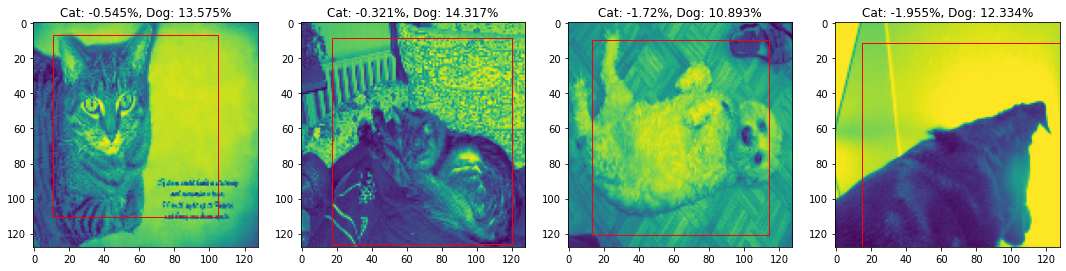

In [155]:
dataiter = iter(train_dataloader0)
outputs = net2(images)
show_result_img(outputs, images, targets)

Unfortunately, our SimpleLinearNet doesn't do well with cats (our model outputs % likelihood, not a firm class guess).  The bounding boxes are also not great, but to be expected for 53/54% accuracy.  A *little* better than flipping a coin!

# Conclusion

We aimed to train a model to predict bounding boxes based on provided images and then predict whether each image was a dog or cat as a classification step, using PyTorch and neural networks. Image classification is a complex machine learning problem. Focusing on a subset of data allowed a short-term project to be approachable. Class prediction based on bounding-boxes alone doesn’t seem to indicate a high probability of success. 

We achieved about 53% accuracy on SimpleLinear and intended to refine FrankenNet transformations to reduce overfitting, and time limitations affected our outcome. Two of our three model training processes function properly, but the more promising requires more work on bounding box predictions. We hope to refine FrankenNet for our final submission.

## Next Steps

Tune FrankenNet model and image transformations to improveprediction performance, accuracy, and fix overfitting problem. Perform additional metric analysis when we have more model results to work with (time limitations).